<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

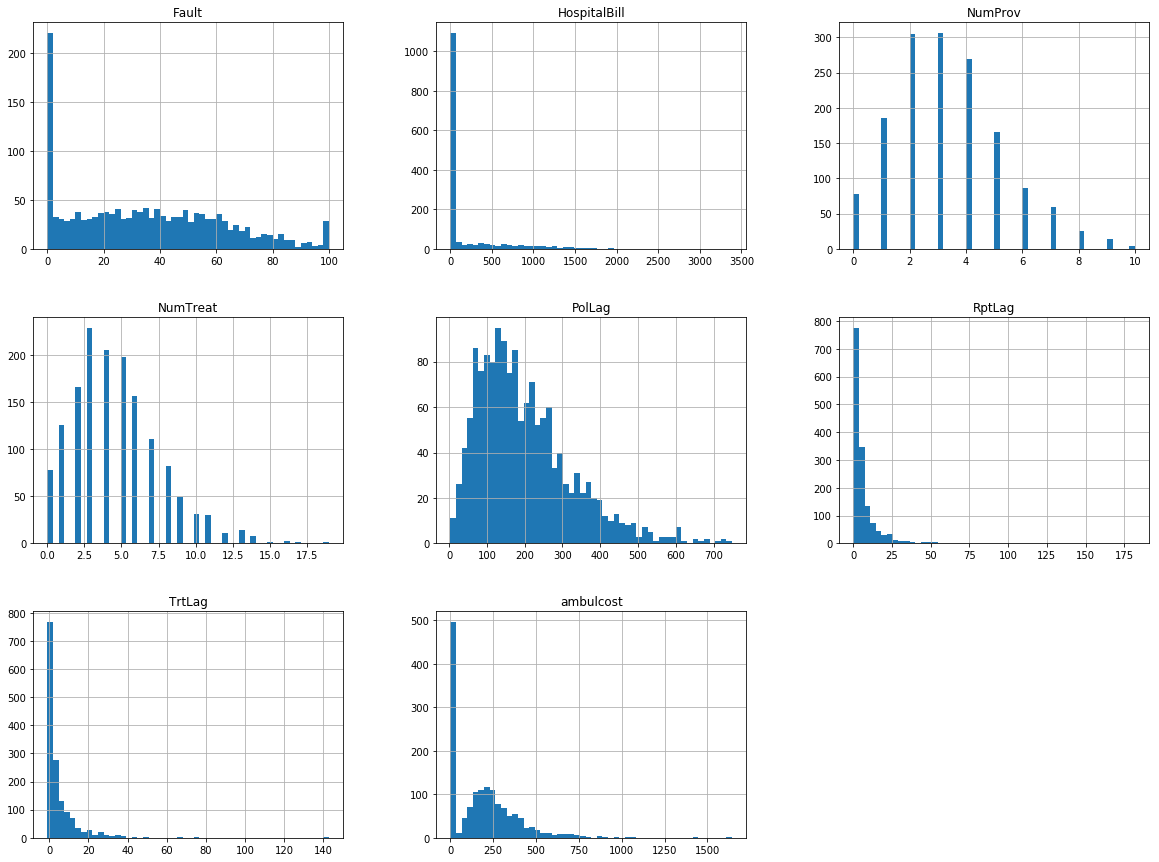

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.naive_bayes import BernoulliNB as BNB


from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_score,recall_score,f1_score,roc_curve,accuracy_score
from sklearn.metrics import precision_recall_curve as prc
#from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score as auc_score
from sklearn.model_selection import cross_val_predict as cvp
#from sklearn.model_selection import cross_val_score as cvs



from sklearn.ensemble import AdaBoostClassifier as Ada
from sklearn.ensemble import GradientBoostingClassifier as GBDT
import xgboost 
import lightgbm
from xgboost import XGBClassifier as XGBC
from lightgbm import LGBMClassifier as LGBC

#lightgbm默认安装在本地python环境中，而anaconda的python路径与本地路径不同，不能使用本地环境中的包，
#因此无法在anaconda jupyter notebook导入lightgbm包。
#conda install -c conda-forge lightgbm
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import ExtraTreesClassifier as ExtraTree
from sklearn.ensemble import BaggingClassifier as Bagging

from mlxtend.classifier import StackingClassifier as Stacking
from sklearn.ensemble import VotingClassifier as Voting


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt
import time
import graphviz
from sklearn import tree as Tree
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from mlxtend.classifier import StackingCVClassifier as StackingCV

import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('SimPIP.csv')
data['Suspicion']-=1
X=data.iloc[:,2:len(data)]
y=data['Suspicion']


#X.describe()

X_cat=[]
X_num=[]
for i in X:
    if (X[i]>2).any():
        X_num.append(i)
    else:
        X_cat.append(i)
X_cat=X[X_cat]
X_num=X[X_num]

X_num.hist(bins=50,figsize=(20,15))

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import robust_scale
from sklearn.pipeline import FeatureUnion
from sklearn_features.transformers import DataFrameSelector
onehot_encoder=OneHotEncoder(sparse=False)

num_attribs = list(X_num)
cat_attribs =list(X_cat)





num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('minmax_scaler', MinMaxScaler(feature_range=(0,1))),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('onehot_encoder',onehot_encoder),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

X_prepared = full_pipeline.fit_transform(X)

#X_train,X_test,y_train,y_test=tts(X_prepared,y,test_size=0.2,random_state=42)

X_train_original,X_test_original,y_train,y_test=tts(X,y,test_size=0.2,random_state=42)
X_train=full_pipeline.fit_transform(X_train_original)
X_test=full_pipeline.fit_transform(X_test_original)

logit=LR()
svm=SVC()
tree=DT()
knn=KNN()
gnb=GNB()
bnb=BNB()
mnb=MNB()

GBM=GBDT()
xgb=XGBC(n_jobs=-1)
lgbm=LGBC(n_jobs=-1)

rf=RF()
extree=ExtraTree()

In [2]:
def Individual(learner,param,methods='predict_proba',train_data=X_train,test_data=X_test,data=X_prepared,scorings='accuracy'):
    time_start=time.clock()

    
    grid_search=GridSearchCV(learner,param,cv=3,scoring=scorings)
    grid_search.fit(train_data,y_train)
    predict=grid_search.predict(test_data)
    time_end=time.clock()
    print(time_end-time_start)
    runtime=time_end-time_start
    
    accuracy=accuracy_score(predict,y_test)
    precision=precision_score(predict,y_test)
    recall=recall_score(predict,y_test)
    f1=f1_score(predict,y_test)
   

    y_scores=cvp(learner,X_prepared,y,cv=3,method=methods)#返回预测值
    if y_scores.ndim>=2:
        y_scores=y_scores[:,1]

    precisions,recalls,thresholds_prc=prc(y,y_scores)
    fpr,tpr,thresholds_roc=roc_curve(y,y_scores)
    auc=auc_score(y,y_scores)
    
    plt.figure(figsize=[12,6])
    
    plt.subplot(121)
    plt.plot(recalls,precisions,'b--',label='precision-recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    
    
    
    plt.subplot(122)
    plt.plot(fpr,tpr,linewidth=2,label='ROC')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend(loc='upper right')
    
    

    return [accuracy,precision,recall,f1,auc,precisions,recalls,fpr,tpr,grid_search.best_params_,grid_search.best_estimator_,runtime]


def Generator(learner,methods='predict_proba',train_data=X_train,test_data=X_test,data=X_prepared):
    time_start=time.clock()
    
    learner.fit(train_data,y_train)
    predict=learner.predict(test_data)
    time_end=time.clock()
    print(time_end-time_start)
    runtime=time_end-time_start
    
    accuracy=accuracy_score(predict,y_test)    
    precision=precision_score(predict,y_test)
    recall=recall_score(predict,y_test)
    f1=f1_score(predict,y_test)
   

    y_scores=cvp(learner,data,y,cv=3,method=methods)#返回预测值
    if y_scores.ndim>=2:
        y_scores=y_scores[:,1]
    
    precisions,recalls,thresholds_prc=prc(y,y_scores)
    fpr,tpr,thresholds_roc=roc_curve(y,y_scores)
    auc=auc_score(y,y_scores)
    
    plt.figure(figsize=[12,6])
    
    plt.subplot(121)
    plt.plot(recalls,precisions,'b--',label='precision-recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    
    
    
    plt.subplot(122)
    plt.plot(fpr,tpr,linewidth=2,label='ROC')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend(loc='upper right')
    
    

    return [accuracy,precision,recall,f1,auc,precisions,recalls,fpr,tpr,learner,runtime]


def Tunning(learner,param,methods='predict_proba',train_data=X_train,test_data=X_test,data=X_prepared,scorings='accuracy'):
    time_start=time.clock()
    
    grid_search=GridSearchCV(learner,param,cv=3,scoring=scorings)
    grid_search.fit(train_data,y_train)
    predict=grid_search.predict(test_data)
    
    time_end=time.clock()
    print(time_end-time_start)
    runtime=time_end-time_start
    
    accuracy=accuracy_score(predict,y_test)
    precision=precision_score(predict,y_test)
    recall=recall_score(predict,y_test)
    f1=f1_score(predict,y_test)
   

    y_scores=cvp(learner,X_prepared,y,cv=3,method=methods)#返回预测值
    if y_scores.ndim>=2:
        y_scores=y_scores[:,1]
     
    precisions,recalls,thresholds_prc=prc(y,y_scores)
    fpr,tpr,thresholds_roc=roc_curve(y,y_scores)
    auc=auc_score(y,y_scores)
    

    return [accuracy,precision,recall,f1,auc,grid_serach.best_prams_,grid_serach.best_estimator_,runtime]



def Base(learner,methods='predict_proba',train_data=X_train,test_data=X_test,data=X_prepared):
    time_start=time.clock()
    
    learner.fit(train_data,y_train)
    predict=learner.predict(test_data)
    
    time_end=time.clock()
    #print(time_end-time_start) 
    runtime=time_end-time_start
    
    accuracy=accuracy_score(predict,y_test)    
    precision=precision_score(predict,y_test)
    recall=recall_score(predict,y_test)
    f1=f1_score(predict,y_test)
   

    y_scores=cvp(learner,data,y,cv=3,method=methods)#返回预测值
    if y_scores.ndim>=2:
        y_scores=y_scores[:,1]


    precisions,recalls,thresholds_prc=prc(y,y_scores)
    fpr,tpr,thresholds_roc=roc_curve(y,y_scores)
    auc=auc_score(y,y_scores)
 
    return [accuracy,precision,recall,f1,auc,learner,runtime]


def plot_tree(classifier,name):
    dot_data= Tree.export_graphviz(classifier, out_file=None,feature_names
                =X.columns,filled=True,special_characters=True) 
    graph_tree = graphviz.Source(dot_data) 
    graph.render(name)
#['accuracy','precision','recall','f1','auc','learner','runtime']

def plot_result(ranges,result):
    accuracy=[i[0] for i in result]
    precision=[i[1] for i in result]
    recall=[i[2] for i in result]
    f1=[i[3] for i in result]
    auc=[i[4] for i in result]
    runtime=[i[-1] for i in result]
    
    plt.figure(figsize=(12, 6))
    plt.title('scores and runtime')

    plt.plot(ranges, accuracy,'b.-',label='Accuracy')
    plt.plot(ranges,precision,'go--',label='Precision')
    plt.plot(ranges,recall,'r-.',label='recall')
    plt.plot(ranges,f1,'c:',label='F1')
    plt.plot(ranges,auc,'m+:',label='AUC')
    #plt.plot(ranges,runtime,'k--',label='runtime')
    plt.legend(loc='upper right')
    plt.xlabel(' Iterations')
    
def plot_feature_importance(result):
    feature_importance=result[-2].feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())#相对最重要的指标
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    plt.figure(figsize=(12, 6))

    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()


2.73543562011041
3.4506754404329008
0.03703117960013991
特征重要度 [0.39712758 0.00385187 0.036116   0.         0.01785667 0.03750446
 0.01201093 0.01470239 0.01440009 0.01185474 0.01867312 0.10863161
 0.01135257 0.00642647 0.00394492 0.01018105 0.00468588 0.01566816
 0.01442039 0.         0.04342607 0.14913409 0.         0.06125648
 0.00677446]
***************************************************************


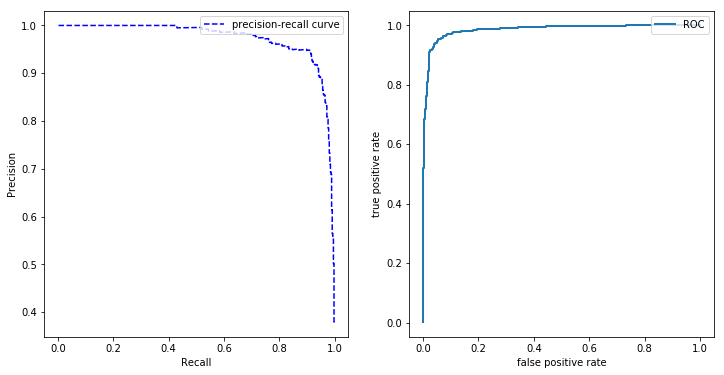

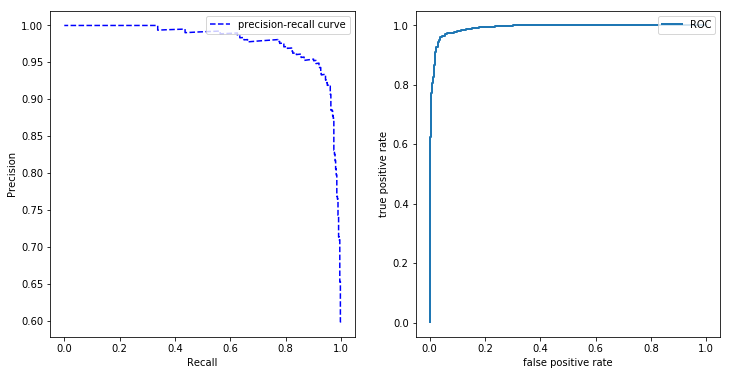

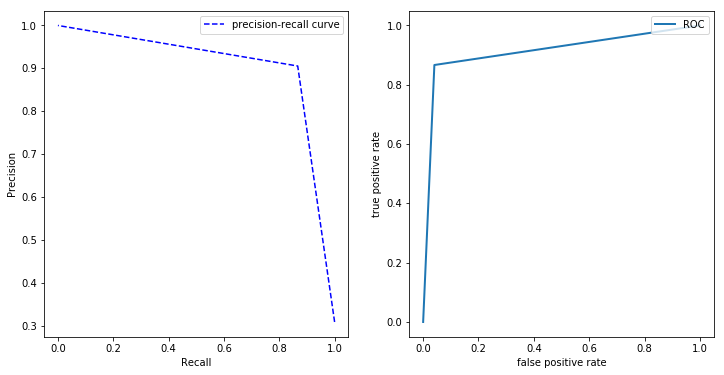

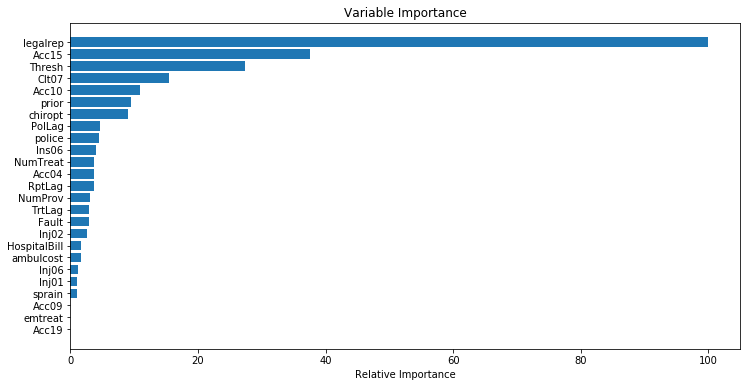

8.391447682806392
0.2159836410636835
0.08183848593936993
0.0028026255307729286
运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98576905]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.99034024]
 [0.96333333 0.91111111 0.96470588 0.93714286 0.91304348]
 [0.97       0.94444444 0.95505618 0.94972067 0.98306893]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94399252]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94628019]
 [0.89       0.93333333 0.75675676 0.8358209  0.93526882]]
**************************************************
最优参数 
 [{'C': 0.30000000000000004, 'penalty': 'l2', 'solver': 'newton-cg'}
 {'C': 0.9, 'kernel': 'rbf'}
 {'criterion': 'entropy', 'splitter': 'random'}
 {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
 {'alpha': 0.1, 'fit_prior': True} {'alpha': 0.1, 'fit_prior': True}]
**************************************************
运行时间 
 [2.73543562e+00 3.45067544e+00 3.70311796e-02 8.39144768e+00
 2.15983641e-01 8.18384859e-02 2.80262553e-03]
******************

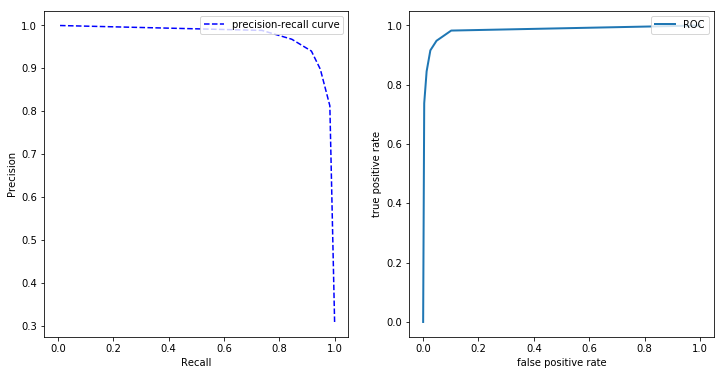

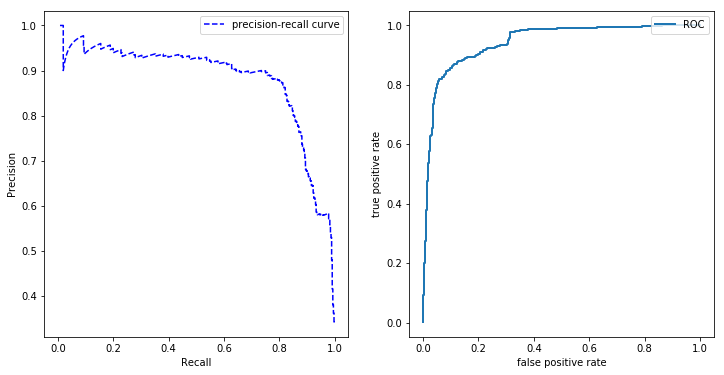

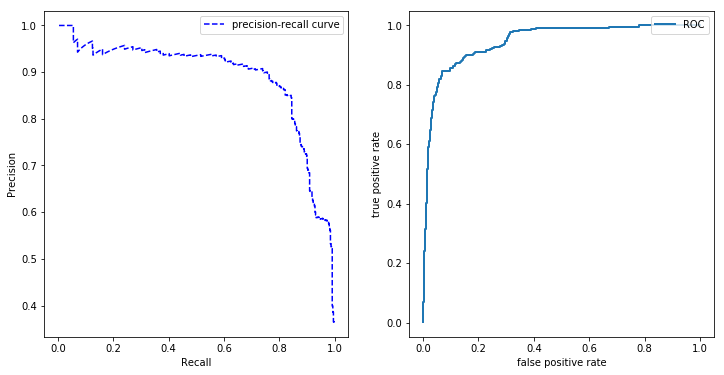

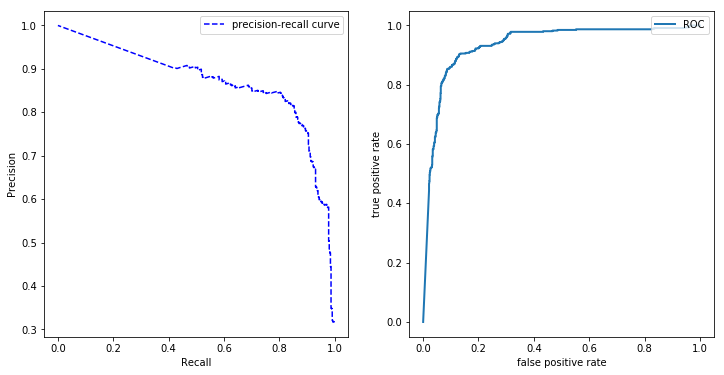

In [3]:
#############################################individual learner###################################################################
logit=LR()
svm=SVC()
tree=DT()
knn=KNN()
gnb=GNB()
bnb=BNB()
mnb=MNB()

logit_param=[{'C':np.arange(0.1,1.1,0.1),'penalty':['l1'],'solver':['liblinear','saga']},
             {'C':np.arange(0.1,1.1,0.1),'penalty':['l2'],'solver':['newton-cg','sag','lbfgs']}]
logit_result=Individual(logit,logit_param,methods='decision_function')


svm_param=[{'C':np.arange(0.1,1.1,0.1),'kernel':['linear', 'poly', 'rbf', 'sigmoid']}]
svm_result=Individual(svm,svm_param,methods='decision_function')

tree_param=[{'criterion':['gini','entropy'],'splitter':['best','random']}]
tree_result=Individual(tree,tree_param,train_data=X_train_original,test_data=X_test_original,data=X)
#树模型不需要进行归一化和one-hot编码
dot_data= Tree.export_graphviz(tree_result[-2], feature_names=X.columns,filled=True,special_characters=True) 
graph_tree = graphviz.Source(dot_data) 
#graph_tree.render('Decision Tree')
print('特征重要度',tree_result[10].feature_importances_)

print('***************************************************************')
plot_feature_importance(tree_result)
knn_param=[{'n_neighbors':np.arange(3,28,2),'weights':['uniform','distance'],'p':[1,2]}]
knn_result=Individual(knn,knn_param,methods='predict_proba')

bnb_param=[{'alpha':np.arange(0.1,1.1,0.1),'fit_prior':[False,True]}]
bnb_result=Individual(bnb,bnb_param,methods='predict_proba')

mnb_param=[{'alpha':np.arange(0.1,1.1,0.1),'fit_prior':[False,True]}]
mnb_result=Individual(mnb,mnb_param,methods='predict_proba')

gnb_result=Generator(gnb)

result_number=np.array([logit_result[:5],svm_result[:5],tree_result[:5],knn_result[:5],bnb_result[:5],mnb_result[:5],gnb_result[:5]])
result_graph=np.array([logit_result[5:9],svm_result[5:9],tree_result[5:9],knn_result[5:9],bnb_result[5:9],mnb_result[5:9],gnb_result[5:9]])
result_best_param=np.array([logit_result[9],svm_result[9],tree_result[9],knn_result[9],bnb_result[9],mnb_result[9]])
result_best_estimator=np.array([logit_result[10],svm_result[10],tree_result[10],knn_result[10],bnb_result[10],mnb_result[10],gnb_result[9]])
result_runtime=np.array([logit_result[-1],svm_result[-1],tree_result[-1],knn_result[-1],bnb_result[-1],mnb_result[-1],gnb_result[-1]])
np.savetxt('result_number.txt',result_number)
np.save('result_graph.npy',result_graph)
np.save('result_best_param.npy',result_best_param)
np.save('result_best_estimator.npy',result_best_estimator)
np.savetxt('runtime.txt',result_runtime)

base_learner=['Logistic Regression','SVM','Decision Tree','kNN','Bernoulli Naive Bayes','Multinomial Naive Bayes','Gaussian Naive Bayes']

print('运行结果','\n', result_number)
print('**************************************************')
print('最优参数','\n',result_best_param)
print('**************************************************')
print('运行时间','\n',result_runtime)
print('**************************************************')
print('***************************************************************')
plot_feature_importance(tree_result)
#######################################################################################################################


In [ ]:
#################################################Ada-optimal##############################################################################
result_number=np.loadtxt('result_number.txt')
result_graph=np.load('result_graph.npy')
result_best_param=np.load('result_best_param.npy')
result_best_estimator=np.load('result_best_estimator.npy')
result_runtime=np.loadtxt('runtime.txt')


Ada_param=[{'n_estimators':np.arange(5,105,5),'learning_rate':np.arange(0.01,1,0.03)}]
Ada_result=[0,0,0,0,0,0,0,0]

Ada_result[0]=Individual(Ada(result_best_estimator[0],algorithm='SAMME'),Ada_param,methods='decision_function')
Ada_result[1]=Individual(Ada(result_best_estimator[1],algorithm='SAMME'),Ada_param,methods='decision_function')
Ada_result[2]=Individual(Ada(result_best_estimator[2],algorithm='SAMME.R'),Ada_param,train_data=X_train_original,
                         test_data=X_test_original,data=X)

Ada_result[4]=Individual(Ada(result_best_estimator[4],algorithm='SAMME.R'),Ada_param,methods='predict_proba')
Ada_result[5]=Individual(Ada(result_best_estimator[5],algorithm='SAMME.R'),Ada_param,methods='predict_proba')
Ada_result[6]=Generator(Ada(gnb))

Ada_result_num=np.array([Ada_result[0][:5],Ada_result[1][:5],Ada_result[2][:5],Ada_result[4][:5],
                         Ada_result[5][:5],Ada_result[6][:5]])

Ada_result_best_param=np.array([Ada_result[0][9],Ada_result[1][9],Ada_result[2][9],Ada_result[4][9],
                         Ada_result[5][9]])

Ada_result_best_estimator=np.array([Ada_result[0][10],Ada_result[1][10],Ada_result[2][10],Ada_result[4][10],
                         Ada_result[5][10],Ada_result[6][9]])

Ada_result_runtime=np.array([Ada_result[0][-1],Ada_result[1][-1],Ada_result[2][-1],Ada_result[4][-1],
                         Ada_result[5][-1],Ada_result[6][-1]])

np.savetxt('Ada_result_num.txt',Ada_result_num)
np.save('Ada_result_best_param.npy',Ada_result_best_param)
np.save('Ada_result_best_estimator.npy',Ada_result_best_estimator)
np.savetxt('Ada_result_runtime.txt',Ada_result_runtime)

print('Adaboost 运行结果','\n',Ada_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Adaboost各学习器的最优参数','\n',Ada_result_best_param)
print('*********************************************************')
print('Adaboost运行时间','\n',Ada_result_runtime)
print('****************************************************')
################################################################

####################################################################################################################################

In [ ]:
GBDT_param=[{'loss':['deviance','exponential'],'learning_rate':np.arange(0.01,1,0.03),'max_depth':np.arange(3,16),
             'n_estimators':np.arange(5,105,5)}]

GBDT_result=Individual(GBM,GBDT_param,train_data=X_train_original,test_data=X_test_original,data=X)
GBDT_result_pre_data=Individual(GBM,GBDT_param)
print('GBDT最优参数','\n',GBDT_result[-3])
print('*********************************************************')
print('Adamnb最优参数','\n',Ada_result_best_param[-1])
np.save('GBDT_result.npy',GBDT_result)
np.save('GBDT_result_pre_data.npy',GBDT_result_pre_data)

In [ ]:


Adamnb_n_estimators=list(np.arange(5,105,5))
Adamnb_learning_rate=list(np.arange(0.01,1.0,0.03))

GBDT_n_estimators=list(np.arange(5,105,5))
GBDT_learning_rate=list(np.arange(0.01,1.0,0.03))
GBDT_depth=list(np.arange(3,16))

for i,j in enumerate(np.arange(5,105,5)):
    GBM_ne=GBDT(n_estimators=j,loss='exponential',learning_rate=0.31,max_depth=5)
    Adamnb_n_estimators[i]=Base(Ada(result_best_estimator[5],algorithm='SAMME.R',n_estimators=j,learning_rate=0.70))
    GBDT_n_estimators[i]=Base(GBM_ne,train_data=X_train_original,test_data=X_test_original,data=X)
    

for i,j in enumerate(np.arange(0.01,1.0,0.03)):
    GBM_lr=GBDT(n_estimators=75,loss='exponential',learning_rate=j,max_depth=5)
    Adamnb_learning_rate[i]=Base(Ada(result_best_estimator[5],algorithm='SAMME.R',n_estimators=60,learning_rate=j))
    GBDT_learning_rate[i]=Base(GBM_lr,train_data=X_train_original,test_data=X_test_original,data=X)


for i,j in enumerate(np.arange(3,16)):
    GBM_md=GBDT(n_estimators=75,loss='exponential',learning_rate=0.31,max_depth=j)
    GBDT_depth[i]=Base(GBM_md,train_data=X_train_original,test_data=X_test_original,data=X)
    
print('GBDT运行结果','\n',GBDT_result[:5])
print('***************************************************************************')
print('GBDT特征重要度:','\n',GBDT_result[-2].feature_importances_)
print('***************************************************************************')
print('GBDT最优参数','\n',GBDT_result[-3])
print('*********************************************************')
print('GBDT运行时间','\n',GBDT_result[-1])
print('***************************************************************************')
np.save('GBDT_n_estimators.npy',GBDT_n_estimators)
np.save('GBDT_learning_rate.npy',GBDT_learning_rate)
np.save('GBDT_depth.npy',GBDT_depth)

np.save('GBDT_result.npy',GBDT_result)
np.save('GBDT_result_pre_data.npy',GBDT_result_pre_data)

np.save('adamnb_n_estimators.npy',Adamnb_n_estimators)
np.save('adamnb_learning_rate.npy',Adamnb_learning_rate)


plot_result(np.arange(5,105,5),GBDT_n_estimators)
plot_result(np.arange(0.01,1,0.03),GBDT_learning_rate)
plot_result(np.arange(3,16),GBDT_depth)

plot_result(np.arange(5,105,5),Adamnb_n_estimators)
plot_result(np.arange(0.01,1,0.03),Adamnb_learning_rate)

plot_feature_importance(GBDT_result)


Adaboost 运行结果 
 [[0.96333333 0.93333333 0.94382022 0.93854749 0.97735806]
 [0.7        0.         0.         0.         0.5       ]
 [0.95       0.91111111 0.92134831 0.91620112 0.92583762]
 [0.95666667 0.95555556 0.90526316 0.92972973 0.77922394]
 [0.96666667 0.96666667 0.92553191 0.94565217 0.9163472 ]
 [0.87666667 0.72222222 0.84415584 0.77844311 0.86564542]]
****************************************************
单学习器运行结果 
 [[0.97       0.96666667 0.93548387 0.95081967 0.98576905]
 [0.97333333 0.96666667 0.94565217 0.95604396 0.99034024]
 [0.93       0.88888889 0.87912088 0.8839779  0.92008727]
 [0.97       0.94444444 0.95505618 0.94972067 0.98306893]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94399252]
 [0.90333333 0.93333333 0.78504673 0.85279188 0.94628019]
 [0.89       0.93333333 0.75675676 0.8358209  0.93526882]]
****************************************************
Adaboost各学习器的最优参数 
 [{'learning_rate': 0.43, 'n_estimators': 95}
 {'learning_rate': 0.01, 'n_estimators': 5}
 {

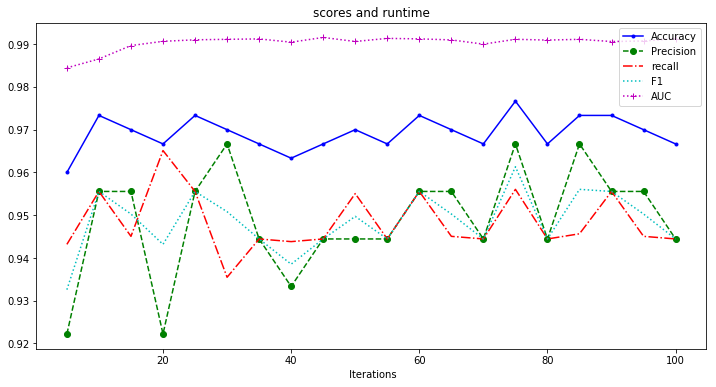

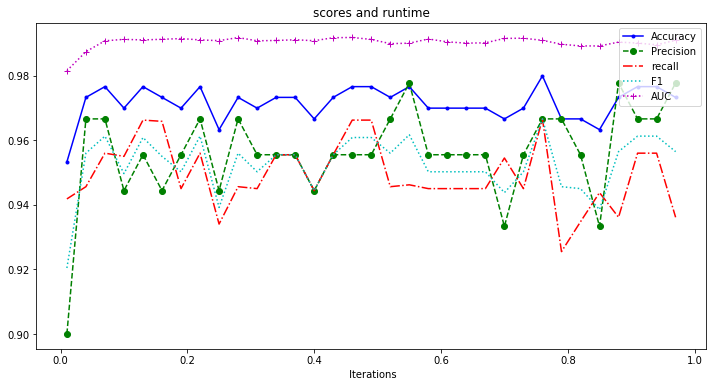

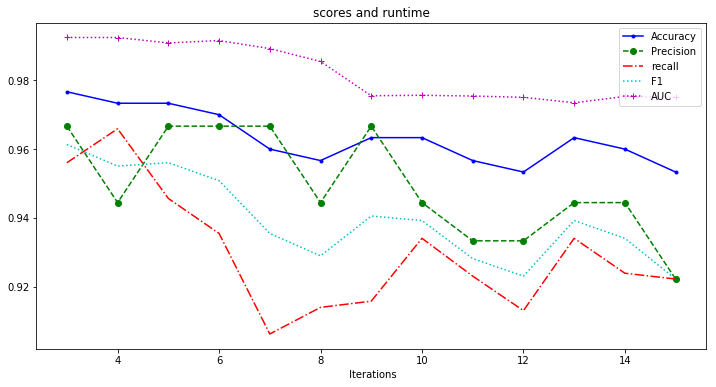

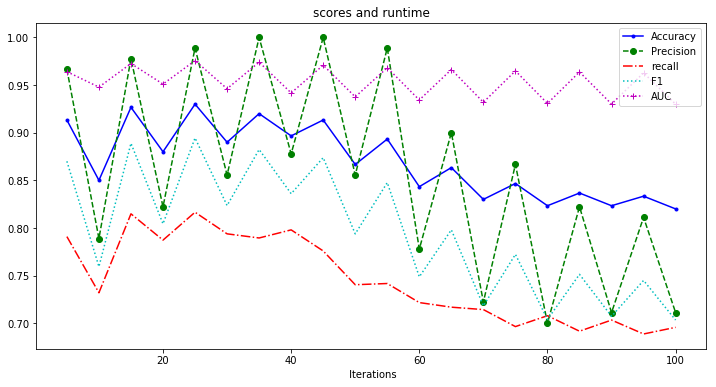

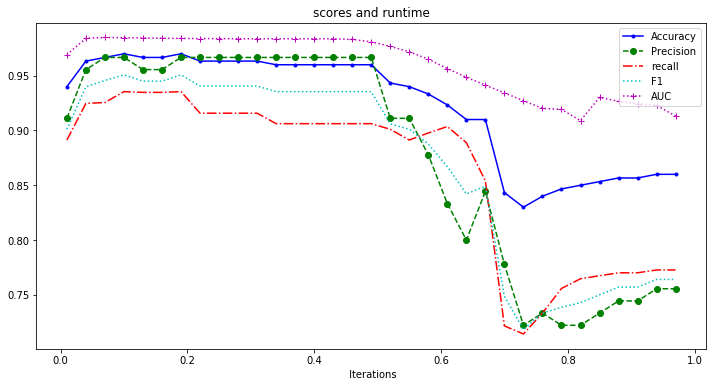

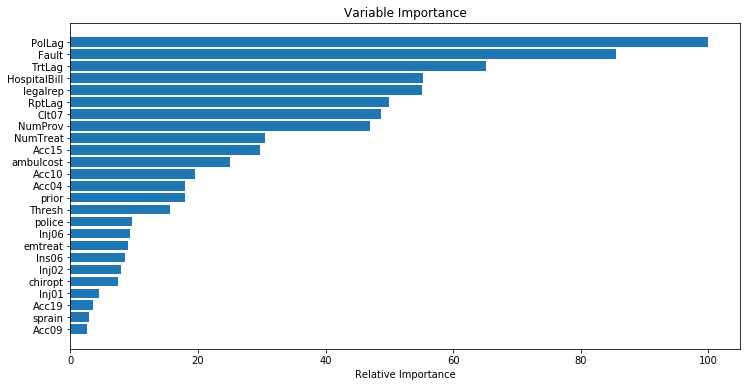

In [4]:
result_number=np.loadtxt('result_number.txt')
result_graph=np.load('result_graph.npy')
result_best_param=np.load('result_best_param.npy')
result_best_estimator=np.load('result_best_estimator.npy')
result_runtime=np.loadtxt('runtime.txt')

Ada_result_num=np.loadtxt('Ada_result_num.txt')
Ada_result_best_param=np.load('Ada_result_best_param.npy')
Ada_result_best_estimator=np.load('Ada_result_best_estimator.npy')
Ada_result_runtime=np.loadtxt('Ada_result_runtime.txt')

GBDT_result=np.load('GBDT_result.npy')
GBDT_result_pre_data=np.load('GBDT_result_pre_data.npy')

GBDT_n_estimators=np.load('GBDT_n_estimators.npy')
GBDT_learning_rate=np.load('GBDT_learning_rate.npy')
GBDT_depth=np.load('GBDT_depth.npy')

GBDT_result=np.load('GBDT_result.npy')
GBDT_result_pre_data=np.load('GBDT_result_pre_data.npy')

Adamnb_n_estimators=np.load('adamnb_n_estimators.npy')
Adamnb_learning_rate=np.load('adamnb_learning_rate.npy')

print('Adaboost 运行结果','\n',Ada_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Adaboost各学习器的最优参数','\n',Ada_result_best_param)
print('*********************************************************')
print('Adaboost运行时间','\n',Ada_result_runtime)
print('****************************************************')

print('GBDT最优参数','\n',GBDT_result[-3])
print('*********************************************************')
print('Adamnb最优参数','\n',Ada_result_best_param[-1])

print('GBDT运行结果','\n',GBDT_result[:5])
print('***************************************************************************')
print('GBDT特征重要度:','\n',GBDT_result[-2].feature_importances_)
print('***************************************************************************')
print('GBDT最优参数','\n',GBDT_result[-3])
print('*********************************************************')
print('GBDT运行时间','\n',GBDT_result[-1])
print('***************************************************************************')

plot_result(np.arange(5,105,5),GBDT_n_estimators)
plot_result(np.arange(0.01,1,0.03),GBDT_learning_rate)
plot_result(np.arange(3,16),GBDT_depth)

plot_result(np.arange(5,105,5),Adamnb_n_estimators)
plot_result(np.arange(0.01,1,0.03),Adamnb_learning_rate)

plot_feature_importance(GBDT_result)

In [ ]:
xgb=XGBC(n_jobs=-1)

train_xgb=xgboost.DMatrix(X_train_original,label=y_train)
test_xgb=xgboost.DMatrix(X_test_original,label=y_test)
X_xgb=xgboost.DMatrix(X,label=y)

train_xgb_pre=xgboost.DMatrix(X_train,label=y_train)
test_xgb_pre=xgboost.DMatrix(X_test,label=y_test)
X_xgb_pre=xgboost.DMatrix(X_prepared,label=y)

xgb_param=[{'max_depth':np.arange(3,16),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_lambda':np.arange(0.1,1.1,0.1)},
           {'max_depth':np.arange(3,16),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_alpha ':np.arange(0.1,1.1,0.1)}
          ]

xgb_result=Individual(xgb,xgb_param,train_data=X_train_original,test_data=X_test_original,data=X)
xgb_result_pre_data=Individual(xgb,xgb_param)





In [ ]:
xgb_n_estimators=list(range(5,105,5))
xgb_learning_rate=list(range(0.01,1,0.03))
xgb_depth=list(range(3,16))
xgb_l1=list(range(0.1,1.1,0.1))
xgb_l2=list(range(0.1,1.1,0.1))

xgb_param_ne=[{'max_depth':np.arange(3,16),'learning_rate':np.arange(0.01,1,0.03),
            'reg_alpha':0,'reg_lambda':np.arange(0.1,1.1,0.1)},
           {'max_depth':np.arange(3,16),'learning_rate':np.arange(0.01,1,0.03),
            'reg_lambda':0,'reg_alpha ':np.arange(0.1,1.1,0.1)}]
for i,j in enumerate(range(5,105,5)):
    xgb_n_estimators[i]=Tunning(xgb(n_estimators=j),xgb_param_ne,train_data=train_xgb,test_data=test_xgb,data=X_xgb)
    
xgb_param_lr=[{'max_depth':np.arange(3,16),'n_estimators':np.arange(5,105,5),
            'reg_alpha':0,'reg_lambda':np.arange(0.1,1.1,0.1)},
           {'max_depth':np.arange(3,16),'n_estimators':np.arange(5,105,5),
            'reg_lambda':0,'reg_alpha ':np.arange(0.1,1.1,0.1)}]
for i,j in enumerate(range(0.01,1,0.03)):
    xgb_learning_rate[i]=Tunning(xgb(learning_rate=j),xgb_param_lr,train_data=train_xgb,test_data=test_xgb,data=X_xgb)

xgb_param_md=[{'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_alpha':0,'reg_lambda':np.arange(0.1,1.1,0.1)},
           {'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_lambda':0,'reg_alpha ':np.arange(0.1,1.1,0.1)}]
for i,j in enumerate(range(3,16)):
    xgb_depth[i]=Tunning(xgb(max_depth=j),xgb_param_md,,train_data=train_xgb,test_data=test_xgb,data=X_xgb)
    
xgb_param_l1=[
           {'max_depth':np.arange(3,16),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_lambda':0,'reg_alpha ':np.arange(0.1,1.1,0.1)}
          ]

for i,j in enumerate(range(0.1,1.1,0.1)):
    xgb_l1[i]=Tunning(xgb(reg_alpha=j),xgb_param_md,,train_data=train_xgb,test_data=test_xgb,data=X_xgb)
    
    
xgb_param_l2=[{'max_depth':np.arange(3,16),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_alpha':0,'reg_lambda':np.arange(0.1,1.1,0.1)}
          ]

for i,j in enumerate(range(0.1,1.1,0.1)):   
    xgb_l2[i]=Tunning(xgb(reg_alpha=j),xgb_param_md,,train_data=train_xgb,test_data=test_xgb,data=X_xgb)
    
    
np.save('xgb_n_estimators.npy',xgb_n_estimators)
np.save('xgb_learning_rate.npy',xgb_learning_rate)
np.save('xgb_depth.npy',xgb_depth)
np.save('xgb_l1.npy',xgb_l1)
np.save('xgb_l2.npy',xgb_l2)

np.save('xgb_result.npy',xgb_result)
np.save('xgb_result_pre_data.npy',xgb_result_pre_data)

print('xgboost结果','\n',xgb_result[:5])
print('*********************************************************')
print('xgboost特征重要度:','\n',xgb_result[-2].feature_importances_)
print('***************************************************************')
print('xgboost最优参数','\n',xgb_result[-3])
print('*********************************************************')
print('xgboost运行时间','\n',xgb_result[-1])

plot_result(np.arange(5,105,5),xgb_n_estimators)
plot_result(np.arange(0.01,1,0.03),xgb_learning_rate)
plot_result(np.arange(1,11),xgb_depth)
plot_result(np.arange(0.1,1.1,0.1),xgb_l1)
plot_result(np.arange(0.1,1.1,0.1),xgb_l2 )

xgboost.plot_tree(xgb_result[-2], num_trees=0, rankdir= 'LR' )
xgboost.plot_importance(xgb_result[-2], num_trees=0, rankdir= 'LR' )
xgboost.to_graphviz(xgb_result[-2], num_trees=0, rankdir= 'LR' )
plot_feature_importance(xgb_result)   
#xgboost.plot_tree(xgb_result[-2].get_booster(),num_tree=0,rankdir='UT')



##################################################lightGBM##################################################################

In [ ]:
lgbm=LGBC(n_jobs=-1,max_bin=,subsample_for_bin=,subsample=,colsample_bytree=)
lgbm_n_estimators=list(range(5,105,5))
lgbm_learning_rate=list(range(0.01,1,0.03))
lgbm_num_leaves=list(range(10,100,3))
lgbm_l1=list(range(0.1,1.1,0.1))
lgbm_l2=list(range(0.1,1.1,0.1))




lgbm_param_ne=[{'num_leaves':np.arange(10,100,3),'learning_rate':np.arange(0.01,1,0.03),
            'reg_alpha':0,'reg_lambda':np.arange(0.1,1.1,0.1)},
           {'num_leaves':np.arange(10,100,3),'learning_rate':np.arange(0.01,1,0.03),
            'reg_lambda':0,'reg_alpha ':np.arange(0.1,1.1,0.1)}]
for i,j in enumerate(range(5,105,5)):
    lgbm_n_estimators[i]=Tunning(lgbm(n_estimators=j),lgbm_param_ne,train_data=train_lgbm,test_data=test_lgbm,data=X_lgbm)

    
    
lgbm_param_lr=[{'num_leaves':np.arange(10,100,3),'n_estimators':np.arange(5,105,5),
            'reg_alpha':0,'reg_lambda':np.arange(0.1,1.1,0.1)},
           {'num_leaves':np.arange(10,100,3),'n_estimators':np.arange(5,105,5),
            'reg_lambda':0,'reg_alpha ':np.arange(0.1,1.1,0.1)}]
for i,j in enumerate(range(0.01,1,0.03)):
    lgbm_learning_rate[i]=Tunning(lgbm(learning_rate=j),lgbm_param_lr,train_data=train_lgbm,test_data=test_lgbm,data=X_lgbm)

    
    
lgbm_param_nl=[{'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_alpha':0,'reg_lambda':np.arange(0.1,1.1,0.1)},
           {'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_lambda':0,'reg_alpha ':np.arange(0.1,1.1,0.1)}]
for i,j in enumerate(range(10,100,3)):
    lgbm_num_leaves[i]=Tunning(lgbm(num_leaves=j),lgbm_param_nl,,train_data=train_lgbm,test_data=test_lgbm,data=X_lgbm)

    
    
lgbm_param_l1=[
           {'num_leaves':np.arange(10,100,3),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_lambda':0,'reg_alpha ':np.arange(0.1,1.1,0.1)}
          ]

for i,j in enumerate(range(0.1,1.1,0.1)):
    lgbm_l1[i]=Tunning(lgbm(reg_alpha=j),lgbm_param_md,,train_data=train_lgbm,test_data=test_lgbm,data=X_lgbm)
    
    
    
    
lgbm_param_l2=[{'num_leaves':np.arange(10,100,3),'learning_rate':np.arange(0.01,1,0.03),'n_estimators':np.arange(5,105,5),
            'reg_alpha':0,'reg_lambda':np.arange(0.1,1.1,0.1)}
          ]

for i,j in enumerate(range(0.1,1.1,0.1)):   
    lgbm_l2[i]=Tunning(lgbm(reg_alpha=j),lgbm_param_md,,train_data=train_lgbm,test_data=test_lgbm,data=X_lgbm)
    


    
    
np.save('lgbm_n_estimators.npy',lgbm_n_estimators)
np.save('lgbm_learning_rate.npy',lgbm_learning_rate)
np.save('lgbm_depth.npy',lgbm_depth)

np.save('lgbm_result.npy',lgbm_result)
np.save('lgbm_result_pre_data.npy',lgbm_result_pre_data)




plot_result(np.arange(5,105,5),lgbm_n_estimators)
plot_result(np.arange(0.01,1,0.03),lgbm_learning_rate)
plot_result(np.arange(10,100,3),lgbm_num_leaves)
plot_result(np.arange(0.1,1.1,0.1),lgbm_l1)
plot_result(np.arange(0.1,1.1,0.1),lgbm_l2 )

lightgbm.plot_tree(lgbm_result[-2], num_trees=0, rankdir= 'LR' )
lightgbm.plot_importance(lgbm_result[-2], num_trees=0, rankdir= 'LR' )
lightgbm.creat_tree_digraph(lgbm_result[-2], num_trees=0, rankdir= 'LR' )
plot_feature_importance(lgbm_result)   
#lgbmoost.plot_tree(lgbm_result[-2].get_booster(),num_tree=0,rankdir='UT')

In [ ]:
#######################################Bagging###############################################################################
#######################################Bagging###############################################################################

Bagging_param=[{'n_estimators':np.arange(5,105,5),'max_samples':np.arange(0.1,1.1,0.1),'max_features':1.0}]
Bagging_result=[0,0,0,0,0,0,0,0]

Bagging_result[0]=Individual(Bagging(result_best_estimator[0]),Bagging_param,methods='decision_function')
Bagging_result[1]=Individual(Bagging(result_best_estimator[1]),Bagging_param,methods='decision_function')
Bagging_result[2]=Individual(Bagging(result_best_estimator[2]),Bagging_param,train_data=X_train_original,
                         test_data=X_test_original,data=X)
Bagging_result[3]=Individual(Bagging(result_best_estimator[3]),Bagging_param,methods='predict_proba')
Bagging_result[4]=Individual(Bagging(result_best_estimator[4]),Bagging_param,methods='predict_proba')
Bagging_result[5]=Individual(Bagging(result_best_estimator[5]),Bagging_param,methods='predict_proba')
Bagging_result[6]=Generator(Bagging(gnb))

Bagging_result_num=np.array([Bagging_result[0][:5],Bagging_result[1][:5],Bagging_result[2][:5],Bagging_result[3][:5],Bagging_result[4][:5],
                         Bagging_result[5][:5],Bagging_result[6][:5]])

Bagging_result_best_param=np.array([Bagging_result[0][9],Bagging_result[1][9],Bagging_result[2][9],Bagging_result[3][9],Bagging_result[4][9],
                         Bagging_result[5][9]])

Bagging_result_best_estimator=np.array([Bagging_result[0][10],Bagging_result[1][10],Bagging_result[2][10],Bagging_result[3][10],
                                        Bagging_result[4][10],Bagging_result[5][10],Bagging_result[6][9]])

Bagging_result_runtime=np.array([Bagging_result[0][-1],Bagging_result[1][-1],Bagging_result[2][-1],,Bagging_result[3][-1],
                                 Bagging_result[4][-1],Bagging_result[5][-1],Bagging_result[6][-1]])

np.savetxt('Bagging_result_num.txt',Bagging_result_num)
np.save('Bagging_result_best_param.npy',Bagging_result_best_param)
np.save('Bagging_result_best_estimator.npy',Bagging_result_best_estimator)
np.savetxt('Bagging_result_runtime.txt',Bagging_result_runtime)

print('Baggingboost 运行结果',Bagging_result_num)
print('****************************************************')
print('单学习器运行结果',result_number)
print('****************************************************')
print('Bagging各学习器的最优参数','\n',Bagging_result_best_param)
print('*********************************************************')
print('Baggingboost运行时间',Bagging_result_runtime)
print('****************************************************')
################################################################

####################################################Random Subspace############################################################################
Subspace_param=[{'n_estimators':np.arange(5,105,5),'max_features':np.arange(0.1,1.1,0.1),'max_samples':1.0,
                 'boostrap':False}]
Subspace_result=[0,0,0,0,0,0,0,0]

Subspace_result[0]=Individual(Bagging(result_best_estimator[0]),Subspace_param,methods='decision_function')
Subspace_result[1]=Individual(Bagging(result_best_estimator[1]),Subspace_param,methods='decision_function')
Subspace_result[2]=Individual(Bagging(result_best_estimator[2]),Subspace_param,train_data=X_train_original,
                         test_data=X_test_original,data=X)
Subspace_result[3]=Individual(Bagging(result_best_estimator[3]),Subspace_param,methods='predict_proba')
Subspace_result[4]=Individual(Bagging(result_best_estimator[4]),Subspace_param,methods='predict_proba')
Subspace_result[5]=Individual(Bagging(result_best_estimator[5]),Subspace_param,methods='predict_proba')
Subspace_result[6]=Generator(Subspace(gnb))

Subspace_result_num=np.array([Subspace_result[0][:5],Subspace_result[1][:5],Subspace_result[2][:5],Subspace_result[3][:5],Subspace_result[4][:5],
                         Subspace_result[5][:5],Subspace_result[6][:5]])

Subspace_result_best_param=np.array([Subspace_result[0][9],Subspace_result[1][9],Subspace_result[2][9],Subspace_result[3][9],Subspace_result[4][9],
                         Subspace_result[5][9]])

Subspace_result_best_estimator=np.array([Subspace_result[0][10],Subspace_result[1][10],Subspace_result[2][10],Subspace_result[3][10],
                                        Subspace_result[4][10],Subspace_result[5][10],Subspace_result[6][9]])

Subspace_result_runtime=np.array([Subspace_result[0][-1],Subspace_result[1][-1],Subspace_result[2][-1],,Subspace_result[3][-1],
                                 Subspace_result[4][-1],Subspace_result[5][-1],Subspace_result[6][-1]])

np.savetxt('Subspace_result_num.txt',Subspace_result_num)
np.save('Subspace_result_best_param.npy',Subspace_result_best_param)
np.save('Subspace_result_best_estimator.npy',Subspace_result_best_estimator)
np.savetxt('Subspace_result_runtime.txt',Subspace_result_runtime)

print('Subspaceboost 运行结果','\n',Subspace_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Subspace各学习器的最优参数','\n',Subspace_result_best_param)
print('*********************************************************')
print('Subspaceboost运行时间','\n',Subspace_result_runtime)
print('****************************************************')
################################################################

#################################################Random Patches##########################################################################
Patches_param=[{'n_estimators':np.arange(5,105,5),'max_feature':np.arange(0.1,1.1,0.1),'max_sample':1.0,'boostrap':True}]
Patches_result=[0,0,0,0,0,0,0,0]

Patches_result[0]=Individual(Bagging(result_best_estimator[0]),Patches_param,methods='decision_function')
Patches_result[1]=Individual(Bagging(result_best_estimator[1]),Patches_param,methods='decision_function')
Patches_result[2]=Individual(Bagging(result_best_estimator[2]),Patches_param,train_data=X_train_original,
                         test_data=X_test_original,data=X)
Patches_result[3]=Individual(Bagging(result_best_estimator[3]),Patches_param,methods='predict_proba')
Patches_result[4]=Individual(Bagging(result_best_estimator[4]),Patches_param,methods='predict_proba')
Patches_result[5]=Individual(Bagging(result_best_estimator[5]),Patches_param,methods='predict_proba')
Patches_result[6]=Generator(Patches(gnb))

Patches_result_num=np.array([Patches_result[0][:5],Patches_result[1][:5],Patches_result[2][:5],Patches_result[3][:5],Patches_result[4][:5],
                         Patches_result[5][:5],Patches_result[6][:5]])

Patches_result_best_param=np.array([Patches_result[0][9],Patches_result[1][9],Patches_result[2][9],Patches_result[3][9],Patches_result[4][9],
                         Patches_result[5][9]])

Patches_result_best_estimator=np.array([Patches_result[0][10],Patches_result[1][10],Patches_result[2][10],Patches_result[3][10],
                                        Patches_result[4][10],Patches_result[5][10],Patches_result[6][9]])

Patches_result_runtime=np.array([Patches_result[0][-1],Patches_result[1][-1],Patches_result[2][-1],,Patches_result[3][-1],
                                 Patches_result[4][-1],Patches_result[5][-1],Patches_result[6][-1]])

np.savetxt('Patches_result_num.txt',Patches_result_num)
np.save('Patches_result_best_param.npy',Patches_result_best_param)
np.save('Patches_result_num.best_estimator',Patches_result_best_estimator)
np.savetxt('Patches_result_runtime.txt',Patches_result_runtime)

print('Patchesboost 运行结果','\n',Patches_result_num)
print('****************************************************')
print('单学习器运行结果','\n',result_number)
print('****************************************************')
print('Patches各学习器的最优参数','\n',Patches_result_best_param)
print('*********************************************************')
print('Patchesboost运行时间','\n',Patches_result_runtime)
print('****************************************************')
################################################################

####################################################################################################################################


In [ ]:
#######################################Bagging optimal##############################################
Bagging_param_ne=[{'max_samples':np.arange(0.1,1.1,0.1),'max_features':1.0}]
Subspace_param_ne=[{'max_features':np.arange(0.1,1.1,0.1),'max_samples':1.0,
                 'boostrap':False}]
Patches_param_ne=[{'max_feature':np.arange(0.1,1.1,0.1),'max_sample':np.arange(0.1,1.1,0.1),'boostrap':True}]

Bagging_result_ne=list(range(5,105,5))
Subspace_result_ne=list(range(5,105,5))
Pathces_result_ne=list(range(5,105,5))
for i,j in enumerate(range(5,105,5)):
    Bagging_result_ne[i]=Tunning(Bagging(n_estimators=j),Bagging_param_ne,)
    Subspace_result_ne[i]=Tunning(Bagging(n_estimators=j),Subspace_param_ne)
    Patches_result_ne[i]=Tunning(Bagging(n_estimators=j),Patches_param_ne)

Bagging_result_sr=list(range(0.1,1.1,0.1))
Subspace_result_sr=list(range(0.1,1.1,0.1))
Pathces_result_sr=list(range(0.1,1.1,0.1))


Bagging_param_sr=[{'n_estimators':np.arange(5,105,5),'max_features':1.0}]
Subspace_param_sr=[{'n_estimators':np.arange(5,105,5),'max_samples':1.0,
                 'boostrap':False}]
Patches_param_sr=[{'n_estimators':np.arange(5,105,5),'boostrap':True}]
for i,j in enumerate(range(0.1,1.1,0.1)):
    Bagging_result_sr[i]=Tunning(Bagging(max_samples=j),Bagging_param_sr)
    Subspace_result_sr[i]=Tunning(Bagging(max_features=j),Subspace_param_sr)
for i,j in enumerate(range(0.1,1.1,0.1)):
    for m,n in enumerate(range(0.1,1.1,0.1)):
        Patches_result_sr[i,m]=Tunning(Bagging(max_samples=j,max_features=n),Patches_param_sr)
        
np.save('Bagging_result_ne.npy',Bagging_result_ne)
np.save('Subspace_result_ne.npy',Subspace_result_ne)
np.save('Patches_result_ne.npy',Patches_result_ne)

np.save('Bagging_result_sr.npy',Bagging_result_sr)
np.save('Subspace_result_sr.npy',Subspace_result_sr)
np.save('Patches_result_sr.npy',Patches_result_sr)

plot_result(np.arange(5,105,5),Bagging_result_ne)
plot_result(np.arange(5,105,5),Subspace_result_ne)
plot_result(np.arange(5,105,5),Patches_result_ne)

plot_result(np.arange(0.1,1.1,0.1),Bagging_result_sr)  
plot_result(np.arange(0.1,1.1,0.1),Subspace_result_sr)  
########???3Dplot#########################################


In [ ]:
#################################random forest#################################################################

rf=RF()
rf_param=[{'n_estimator':np.arange(5,105,5),'criterion':['gini','entropy'],'max_depth':np.arange(3,16),'n_jobs':-1}]
rf_result=Individual(rf,rf_param,train_data=X_train_original,
                         test_data=X_test_original,data=X)
rf_result_pre_data=Individual(rf,rf_param)
rf_result_ne=list(range(5,105,5))
rf_result_md=list(range(3,16))
rf_param_ne=[{'criterion':['gini','entropy'],'max_depth':np.arange(3,16),'n_jobs':-1}]
for i in range(5,105,5):
    rf_result_ne[i]=Tunning(rf(n_estimators=j),rf_param_ne,train_data=X_train_original,test_data=X_test_original,data=X))
for i in range(3,16):
    rf_result_md[i]=Tunning(rf(max_depth=j),rf_result_md,train_data=X_train_original,test_data=X_test_original,data=X))
np.save('rf_result.npy',rf_result)
np.save('rf_result_pre_data.npy',rf_result_pre_data)
np.save('rf_result_ne.npy',rf_result_ne)
np.save('rf_result_md.npy',rf_result_md)


print('random forest结果','\n',rf_result[:5])
print('*********************************************************')
print('random forest特征重要度:','\n',rf_result[-2].feature_importances_)
print('***************************************************************')
print('random forest最优参数','\n',rf_result[-3])
print('*********************************************************')
print('random forest运行时间','\n',rf_result[-1])




plot_result(np.arange(5,105,5),rf_result_ne)

plot_result(np.arange(1,11),rf_result_md)   

plot_feature_importance(rf_result)


In [ ]:
#################################extra tree#################################################################

extree=ExtraTree()
extree_param=[{'n_estimator':np.arange(5,105,5),'criterion':['gini','entropy'],'max_depth':np.arange(3,16),'n_jobs':-1,'boostrap':True}]
extree_result=Individual(extree,extree_param,train_data=X_train_original,test_data=X_test_original,data=X)
extree_result_pre_data=Individual(extree,extree_param)
extree_result_ne=list(range(5,105,5))
extree_result_md=list(range(3,16))
extree_param_ne=[{'criterion':['gini','entropy'],'max_depth':np.arange(3,16),'n_jobs':-1}]
for i,j in enumerate(range(5,105,5)):
    extree_result_ne[i]=Tunning(extree(n_estimators=j),extree_param_ne,train_data=X_train_original,test_data=X_test_original,data=X)
for i,j in enumerate(range(3,16)):
    extree_result_md[i]=Tunning(extree(max_depth=j),extree_result_md,train_data=X_train_original,test_data=X_test_original,data=X))
np.save('extree_result.npy',extree_result)
np.save('extree_result_pre_data.npy',extree_result_pre_data)

np.save('extree_result_ne.npy',extree_result_ne)
np.save('extree_result_md.npy',extree_result_md)

print('ExtraTree结果','\n',extree_result[:5])
print('*********************************************************')
print('ExtraTree特征重要度:','\n',extree_result[-2].feature_importances_)
print('***************************************************************')
print('ExtraTree最优参数','\n',extree_result[-3])
print('*********************************************************')
print('ExtraTree运行时间','\n',extree_result[-1])

plot_result(np.arange(5,105,5),extree_result_ne)

plot_result(np.arange(3,16),extree_result_md)   

plot_feature_importance(extree_result)





In [ ]:
################################Stacking###########################################################################
meta=LR()
?Stacking
param_stacking={'use_probas':True,'average_probas':[True,False],'use_features_in_secondary':[True,False]}
stacking_base=result_best_estimator
stacking_boosting=[Ada_result_best_estimator[],GBDT_result[-2],xgb_result[-2],lgbm_result[-2]]
stacking_bagging=[Bagging_result_best_estimator[],Subspace_result_best_estimator[],Patches_result_best_estimator[],
                  rf_result[-2],extree_result[-2]]
stacking_ensemble=[Ada_result_best_estimator[],GBDT_result[-2],xgb_result[-2],lgbm_result[-2],
                   Bagging_result_best_estimator[],Subspace_result_best_estimator[],Patches_result_best_estimator[],
                  rf_result[-2],extree_result[-2]]
stacking_blended=[]
for i in stacking_base:
    stacking_blended.append(i)
for i in stacking_ensemble:
    stacking_blended.append(i)

stacking_result_nonproba_pre_data=[0,0,0,0,0]
stacking_result_proba_pre_data=[0,0,0,0,0]

for i,classifier in enumerate([stacking_base,stacking_boosting,stacking_bagging,stacking_ensemble,stacking_belended]):
    stacking_result_nonproba_pre_data[i]=Generator(StackingCV(classfiers=classifier,meta_classifier=meta))
    
for i,classifier in enumerate([stacking_base,stacking_boosting,stacking_bagging,stacking_ensemble,stacking_belended]):
    stacking_result_proba_pre_data[i]=Individual(StackingCV(classfiers=classifier,meta_classifier=meta),param=param_stacking)
    
    
stacking_result_nonproba=[0,0,0,0,0]
stacking_result_proba=[0,0,0,0,0]

for i,classifier in enumerate([stacking_base,stacking_boosting,stacking_bagging,stacking_ensemble,stacking_belended]):
    stacking_result_nonproba[i]=Generator(StackingCV(classfiers=classifier,meta_classifier=meta),
                                                      train_data=X_train_original,test_data=X_test_original,data=X)
    
for i,classifier in [stacking_base,stacking_boosting,stacking_bagging,stacking_ensemble,stacking_belended]:
    stacking_result_proba[i]=Individual(StackingCV(classfiers=classifier,meta_classifier=meta),param=param_stacking,
                                                   train_data=X_train_original,test_data=X_test_original,data=X)
    
np.save('stacking_result_nonproba_pre_data.npy',stacking_result_nonproba_pre_data)
np.save('stacking_result_proba_pre_data.npy',stacking_result_proba_pre_data)
np.save('stacking_result_nonproba.npy',stacking_result_nonproba)
np.save('stacking_result_proba.npy',stacking_result_proba)


print('stacking_result_nonproba_pre_data结果','\n',stacking_result_nonproba_pre_data[:][:5])
print('*********************************************************')
print('stacking_result_nonproba_pre_data运行时间','\n',stacking_result_nonproba_pre_data[:][-1])
print('*********************************************************')


print('stacking_result_nonproba结果','\n',stacking_result_nonproba[:][:5])
print('*********************************************************')
print('stacking_result_nonproba运行时间','\n',stacking_result_nonproba[:][-1])
print('*********************************************************')

print('stacking_result_proba_pre_data结果','\n',stacking_result_proba_pre_data[:][:5])
print('*********************************************************')
print('stacking_result_proba_pre_data最优参数','\n',stacking_result_proba_pre_data[:][-3])
print('*********************************************************')
print('stacking_result_proba_pre_data运行时间','\n',stacking_result_proba_pre_data[:][-1])

print('*********************************************************')
print('stacking_result_proba结果','\n',stacking_result_proba[:][:5])
print('*********************************************************')
print('stacking_result_proba最优参数','\n',stacking_result_proba[:][-3])
print('*********************************************************')
print('stacking_result_proba运行时间','\n',stacking_result_proba[:][-1])
